## Keystone Homes - Final Data Science Project

Miriam Shamash, Natalia Cedeno, Zizel Delikanaki, Shsihir Jamadagni


## Part One: International Enrollment and Boston Rent Trends


**Goal:**  
Track international student enrollment over time and compare it with rental price trends to identify correlations between enrollment levels and rent costs.

In this section, we:

- Load & clean enrollment data from Open Doors and rent data from Zillow.  
- Filter for Boston‑area universities and ZIP codes.  
- Aggregate each dataset by year to form two core time series.  
- Merge the series to align rent prices with international enrollment levels.  
- Train & evaluate a linear regression model to quantify how changes in international student numbers relate to rent increases.

This analysis reveals whether neighborhoods with growing international student populations tend to see higher rents.  

## Step 1: Load and Clean Zillow Rent Data

This section loads Zillow's rental price time series data and prepares it for analysis.

- We filter the dataset to include only ZIP codes in Massachusetts.
- The data is converted from wide format (one column per date) to long format, where each row contains a ZIP code, date, and rent value.
- A new column is created to extract the year from the date.
- We then calculate the average rent for each year across all ZIP codes in Massachusetts.
- This aggregated data will later be merged with student enrollment data to analyze trends over time.


In [ ]:
import pandas as pd

zillow_path = "zillow-all-homes-plus-multifamily-time-series-zipcode.csv"  
df_zillow = pd.read_csv(zillow_path)

# Filter to Massachusetts ZIP codes
df_zillow_ma = df_zillow[df_zillow['State'] == 'MA']

# Keep ZIP and time series columns
time_cols = [col for col in df_zillow_ma.columns if col.startswith('20')]
columns_to_keep = ['RegionName'] + time_cols
df_zillow_ma = df_zillow_ma[columns_to_keep]

# Convert to long format (RegionName = ZIP, Date, Rent)
df_zillow_long = df_zillow_ma.melt(id_vars=['RegionName'], var_name='Date', value_name='Rent')
df_zillow_long['Date'] = pd.to_datetime(df_zillow_long['Date'])
df_zillow_long['Year'] = df_zillow_long['Date'].dt.year

# Average rent across all Boston ZIPs per year
df_rent_yearly = df_zillow_long.groupby('Year')['Rent'].mean().reset_index()
df_rent_yearly.rename(columns={'Rent': 'Avg_Boston_Rent'}, inplace=True)


## Step 2: Load and Filter International Student Enrollment Data

In this step, we use Open Doors data to extract international student enrollment numbers for universities located in Massachusetts.

- We load an Excel workbook containing international enrollment counts by institution type (doctoral, master’s, etc.).
- A list of cities in Massachusetts is used to identify student-heavy areas (including Boston, Cambridge, Amherst, Worcester, etc.).
- The Excel sheets are structured with repeated panels across columns, so we write a function to extract each panel’s columns (Institution, City, State, and International Students).
- We filter each panel to include only institutions located in Massachusetts and only those within our defined student-city list.
- The results are tagged with the year (in this case, assumed to be 2023) and concatenated into one DataFrame.
- Finally, we group the data by city and year to compute the total number of international students per city.

This structured and cleaned dataset will later be merged with city-level rent data to analyze potential relationships between international student presence and housing prices.


In [6]:
# Load Excel workbook
file_path = "Census_Leading-Institutions-by-Institutional-Type_OD24_Website.xlsx"
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

# Cities within ~20 miles of Boston
nearby_cities = [
    # Original Boston Metro (~20-mile radius)
    'BOSTON', 'CAMBRIDGE', 'BROOKLINE', 'SOMERVILLE', 'MEDFORD', 'WALTHAM',
    'NEWTON', 'QUINCY', 'MALDEN', 'CHELSEA', 'EVERETT', 'REVERE',
    'WATERTOWN', 'ARLINGTON', 'BELMONT', 'BRIGHTON', 'DORCHESTER',
    'ALLSTON', 'JAMAICA PLAIN',

    # Expanded University Towns (3,000+ students)
    'WORCESTER',     # Clark, WPI, Holy Cross, UMass Chan
    'LOWELL',        # UMass Lowell
    'AMHERST',       # UMass Amherst, Amherst College, Hampshire College
    'SPRINGFIELD',   # Springfield College, AIC
    'DARTMOUTH',     # UMass Dartmouth
    'BRIDGEWATER',   # Bridgewater State University
    'FITCHBURG',     # Fitchburg State
    'SALEM',         # Salem State
    'FRAMINGHAM',    # Framingham State
    'WESTFIELD',     # Westfield State
    'CHICOPEE',      # Elms College
    'MILTON',        # Curry College
    'BEVERLY',       # Endicott College
    'NORTHAMPTON',   # Smith College
    'MOUNT HOLYOKE', # Mount Holyoke College (sometimes listed as South Hadley)
    'SOUTH HADLEY',  # Just in case some schools are filed under this
    'NORTHAMPTON',   # Smith College
    'DUDLEY',        # Nichols College
    'WESTON',        # Regis College
    'HINGHAM',       # Derby Academy + smaller campuses
]

# Function to extract data from a horizontally structured sheet
def extract_from_sheet(sheet_name, year):
    df_raw = pd.read_excel(xls, sheet_name=sheet_name, skiprows=2)
    extracted_rows = []

    for i in range(0, 21):  # Up to 'Int'l Students.20'
        inst_col = f'Institutions{"" if i == 0 else f".{i}"}'
        city_col = f'City{"" if i == 0 else f".{i}"}'
        state_col = f'State{"" if i == 0 else f".{i}"}'
        intl_col = f"Int'l Students{'' if i == 0 else f'.{i}'}"

        # Skip if any required column is missing
        if all(col in df_raw.columns for col in [inst_col, city_col, state_col, intl_col]):
            panel = df_raw[[inst_col, city_col, state_col, intl_col]].copy()
            panel.columns = ['Institution', 'City', 'State', 'Intl_Students']
            panel['City'] = panel['City'].astype(str).str.upper()
            panel = panel[panel['State'] == 'MA']
            panel = panel[panel['City'].isin(nearby_cities)]
            panel['Year'] = year
            extracted_rows.append(panel)

    if extracted_rows:
        return pd.concat(extracted_rows, ignore_index=True)
    else:
        return pd.DataFrame()

# Process all sheets assuming they represent 2023
df_all = pd.concat([extract_from_sheet(sheet, 2023) for sheet in sheet_names], ignore_index=True)

# Group by city and year instead of just year
df_by_city_year = df_all.groupby(['Year', 'City'])['Intl_Students'].sum().reset_index()
df_by_city_year = df_by_city_year.sort_values(by='Intl_Students', ascending=False)

# Display top rows
df_by_city_year.head()

,Year,City,Intl_Students
1,2023,BOSTON,433696.0
2,2023,CAMBRIDGE,151492.0
7,2023,WALTHAM,18158.0
6,2023,SOUTH HADLEY,12206.0
4,2023,NORTHAMPTON,7207.0


## Step 3: Map ZIP Codes to Cities and Aggregate Rent Data

In this step, we enrich the Zillow rent dataset by mapping ZIP codes to their corresponding city names and aggregating rent values at the city level.

- We load a ZIP code database that includes all U.S. ZIP codes along with their city and state information.
- The dataset is filtered to include only ZIP codes located in Massachusetts.
- We extract and standardize the relevant fields (ZIP code and city name), ensuring consistent formatting for merging.
- Zillow’s ZIP codes are also standardized using string formatting and zero-padding.
- We then merge the Zillow rent data with the ZIP-to-city mapping using ZIP code as the key.
- Any rows with missing city names are dropped to ensure clean aggregation.
- Finally, we compute the average rent per city per year by grouping the data on both columns.

This city-level rent dataset will later be merged with international student counts to analyze how enrollment trends may influence housing prices at a local level.


In [7]:
# Load the ZIP code to city mapping CSV
zip_df = pd.read_csv('zip-codes-database-FREE.csv')

# Filter for Massachusetts ZIP codes
ma_zip_df = zip_df[zip_df['State'] == 'MA']

# Extract just the ZipCode and City columns
ma_zip_city_df = ma_zip_df[['ZipCode', 'City']].copy()

# Standardize formatting
ma_zip_city_df['City'] = ma_zip_city_df['City'].str.upper()
ma_zip_city_df['ZipCode'] = ma_zip_city_df['ZipCode'].astype(str).str.zfill(5)

# Ensure ZIPs in Zillow are also strings and zero-padded
df_zillow_long['ZIP'] = df_zillow_long['RegionName'].astype(str).str.zfill(5)

# Merge ZIP → City info into Zillow data
df_zillow_mapped = df_zillow_long.merge(
    ma_zip_city_df,
    left_on='ZIP',
    right_on='ZipCode',
    how='left'
)

# Drop any rows with missing city values
df_zillow_mapped = df_zillow_mapped.dropna(subset=['City'])

# Aggregate rent by City + Year
df_rent_city_year = df_zillow_mapped.groupby(['City', 'Year'])['Rent'].mean().reset_index()

df_rent_city_year = df_rent_city_year.dropna(subset=['Rent'])

df_rent_city_year

,City,Year,Rent
10,ABINGTON,2025,2760.067766
21,ACTON,2025,2505.495703
22,ALLSTON,2015,2199.787249
23,ALLSTON,2016,2309.540567
24,ALLSTON,2017,2386.973100
...,...,...,...
1304,WORCESTER,2021,1659.052958
1305,WORCESTER,2022,1839.304748
1306,WORCESTER,2023,1953.935437
1307,WORCESTER,2024,2070.201056


## Step 4: Linear Regression – International Enrollment vs. Rent Prices

In the final step of our analysis, we build a linear regression model to quantify the relationship between international student enrollment and average rent prices across Massachusetts cities.

- We merge the cleaned international enrollment dataset with the city-level rent data, using `City` and `Year` as keys.
- We drop any rows with missing or zero values to ensure valid inputs for the model.
- A simple linear regression model is fit using international enrollment as the independent variable and average rent as the dependent variable.
- We print the model’s coefficient, intercept, and R² value to interpret the strength and direction of the relationship.
- Finally, we visualize the regression by plotting actual data points and the best-fit line.

This analysis helps us determine whether cities with larger international student populations tend to have higher rent prices, providing insight into how enrollment trends may influence the housing market.


Linear Regression Results
Coefficient: 0.0020 (rent increase per additional student)
Intercept: 2622.15
R² score: 0.4019


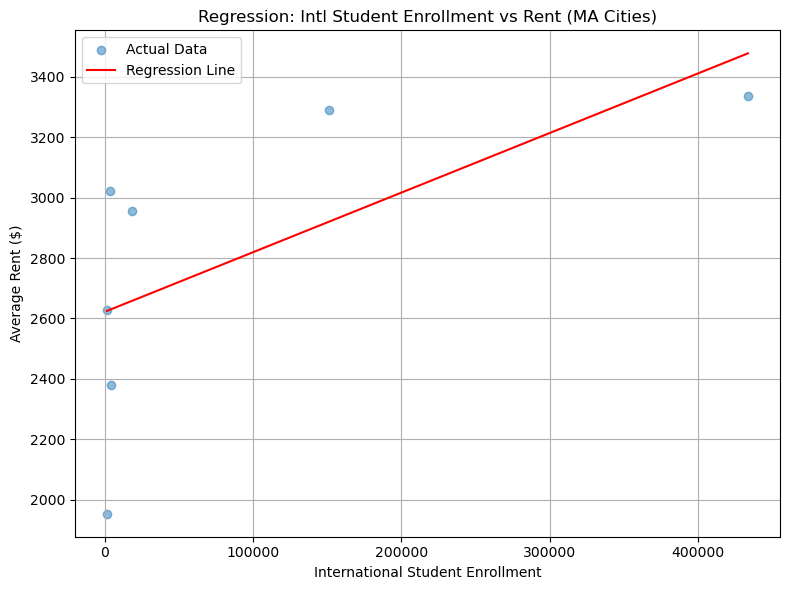

In [8]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Merge Enrollment and Rent Data
df_compare_city = pd.merge(
    df_by_city_year,
    df_rent_city_year,
    on=['City', 'Year'],
    how='inner'
).rename(columns={
    'Intl_Students': 'International_Enrollment',
    'Rent': 'Avg_Rent'
})

# Clean Missing or Zero Values
df_compare_city = df_compare_city.dropna(subset=['International_Enrollment', 'Avg_Rent'])
df_compare_city = df_compare_city[df_compare_city['International_Enrollment'] > 0]

# Fit Linear Regression Model
X = df_compare_city[['International_Enrollment']]
y = df_compare_city['Avg_Rent']

model = LinearRegression()
model.fit(X, y)

# Print Model Results
print("Linear Regression Results")
print(f"Coefficient: {model.coef_[0]:.4f} (rent increase per additional student)")
print(f"Intercept: {model.intercept_:.2f}")
print(f"R² score: {model.score(X, y):.4f}")

# Plot Regression
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.5, label='Actual Data')
plt.plot(X, model.predict(X), color='red', label='Regression Line')
plt.xlabel('International Student Enrollment')
plt.ylabel('Average Rent ($)')
plt.title('Regression: Intl Student Enrollment vs Rent (MA Cities)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary of Our Findings

Our analysis explored the relationship between international student enrollment and average rent prices across Massachusetts cities using data from Open Doors and Zillow.

After cleaning and aggregating both datasets, we built a linear regression model using international student enrollment as the predictor for average rent.

**Key findings:**
- The model showed a positive but small relationship between enrollment and rent. For every 1,000 additional international students, rent increased by approximately $2.
- The model’s R² score was 0.40, meaning international student enrollment explains about 40% of the variation in rent prices across city-years.
- While this suggests a moderate correlation, it also indicates that other factors play a larger role in determining rent trends.

Overall, international student presence appears to be one of several contributing factors to rising rents, but not a dominant one on its own.

## Our Recommendations

### 1. Don't rely on enrollment alone
- International student growth gives us some insight, but it’s only part of the bigger picture.
- We can combine it with other drivers like job growth, income trends, and housing supply.
- It should be a supporting factor, not the core of a rent forecast.

### 2. Focus on cities where enrollment is climbing
- Rising international enrollment can signal stronger demand.
- By tracking city and school-level trends, we can spot opportunities earlier.
- Focus on places where student growth is moving faster than housing supply.

### 3. Add more layers to the analysis
- International students explain some of the rent changes — but not everything.
- We should pull in data on incomes, new construction, and employment to get a fuller picture.
- A multi-factor model will lead to stronger investment and planning decisions.

-----------------------------------------------------------------------------------------------------------------------------------------------


## Part Two: Integrated Condition Modeling & Complaint Context

### Goal:
Predict building condition and incorporate neighborhood‐level complaint patterns to better understand maintenance outcomes in student-housing areas.

### In this section, we:
1. Load and clean the Boston property assessment data, restricting to core off-campus neighborhoods.
2. Convert interior and exterior ratings into numeric scores (`INT_SCORE`, `EXT_SCORE`).
3. Engineer owner type and basic property features (e.g., number of units, assessed values).
4. Load and pivot 311 housing-related complaints for the same student neighborhoods.
5. Merge the complaint counts back onto each property so each record includes both building attributes and local complaint context.
6. Split the data into train/validation/test sets (60%/20%/20%), scale features, then:
   - Classify `INT_SCORE` using a Random Forest classifier
   - Regress `INT_SCORE` using a Random Forest regressor
7. Evaluate performance on both tasks to determine whether complaint context improves our ability to predict maintenance quality.

### Research Question:
Does landlord type, property metrics, and the surrounding complaint environment together explain interior condition in student-rented buildings?


## Step 1: Load & Filter Data

- Load the property CSV and convert all column names to uppercase.  
- Restrict to neighborhoods with large student populations (e.g., Allston, Cambridge).









In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# File paths
PROP_PATH = "boston-fy2025-property-assessment-data_12_30_2024.csv"
SVC_PATH = "boston-311-metadata.csv"

# Load property assessment data and convert column names to uppercase
df = pd.read_csv(PROP_PATH, low_memory=False)
df.columns = df.columns.str.upper()

# Keep only student-heavy neighborhoods
student_cities = [
    'ALLSTON', 'FENWAY', 'BACK BAY', 'CAMBRIDGE', 'SOMERVILLE', 'MEDFORD',
    'BROOKLINE', 'JAMAICA PLAIN', 'BRIGHTON', 'DORCHESTER', 'CHARLESTOWN',
    'EAST BOSTON', 'HYDE PARK', 'MISSION HILL', 'BEACON HILL', 'SEAPORT',
    'SOUTH BOSTON', 'SOUTH END', 'ROSLINDALE', 'ROXBURY', 'WEST ROXBURY'
]

df = df[df['CITY'].str.upper().isin(student_cities)].copy()

# Preview data
df.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NUM2,ST_NAME,UNIT_NUM,CITY,ZIP_CODE,BLDG_SEQ,...,KITCHEN_STYLE2,KITCHEN_STYLE3,HEAT_TYPE,HEAT_SYSTEM,AC_TYPE,FIREPLACES,ORIENTATION,NUM_PARKING,PROP_VIEW,CORNER_UNIT
0,100001000,NaN,100001000,104.0,NaN,PUTNAM ST,NaN,EAST BOSTON,2128.0,1,...,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,0.0,NaN,3.0,A - Average,NaN
1,100002000,NaN,100002000,197.0,NaN,Lexington ST,NaN,EAST BOSTON,2128.0,1,...,M - Modern,M - Modern,F - Forced Hot Air,NaN,C - Central AC,0.0,NaN,0.0,A - Average,NaN
2,100003000,NaN,100003000,199.0,NaN,Lexington ST,NaN,EAST BOSTON,2128.0,1,...,S - Semi-Modern,S - Semi-Modern,S - Space Heat,NaN,N - None,0.0,NaN,0.0,A - Average,NaN
3,100004000,NaN,100004000,201.0,NaN,Lexington ST,NaN,EAST BOSTON,2128.0,1,...,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,0.0,NaN,0.0,A - Average,NaN
4,100005000,NaN,100005000,203.0,NaN,Lexington ST,NaN,EAST BOSTON,2128.0,1,...,N - No Remodeling,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,0.0,NaN,0.0,A - Average,NaN


## Step 2: Clean & Feature‐Engineer

- Remove commas and convert monetary fields (`TOTAL_VALUE`, `LAND_VALUE`, `BLDG_VALUE`) to numeric floats.  
- Extract the text ratings (after “–”) from `INT_COND` and `EXT_COND`, then map to integer scores (1–5).  
- Sum to a combined score (2–10) and bucket into **“Low” / “Medium” / “High.”**  
- Simplify `OWNER` into categories (**Company**, **Institutional**, **Individual**, **Unknown**) and encode as numeric.









In [10]:
# Drop rows with missing interior or exterior condition
df = df.dropna(subset=['INT_COND', 'EXT_COND'])

# Clean monetary fields and convert to float
for c in ['TOTAL_VALUE', 'LAND_VALUE', 'BLDG_VALUE']:
    df[c] = (
        df[c]
        .astype(str)
        .str.replace(',', '', regex=False)
        .astype(float)
    )

# Extract rating text after any dash, strip, uppercase
def extract_label(s):
    if not isinstance(s, str):
        return ''
    parts = s.split('-', 1)
    return parts[-1].strip().upper()

df['INT_LABEL'] = df['INT_COND'].apply(extract_label)
df['EXT_LABEL'] = df['EXT_COND'].apply(extract_label)

# Map condition labels to numeric scores
score_map = {'POOR': 1, 'FAIR': 2, 'AVERAGE': 3, 'GOOD': 4, 'EXCELLENT': 5}
df['INT_SCORE'] = df['INT_LABEL'].map(score_map)
df['EXT_SCORE'] = df['EXT_LABEL'].map(score_map)

# Drop rows with unmapped scores
df = df.dropna(subset=['INT_SCORE', 'EXT_SCORE'])

# Calculate combined score and assign condition class
df['COMBINED_SCORE'] = df['INT_SCORE'] + df['EXT_SCORE']

def bucket(cs):
    if cs <= 4:
        return 'Low'
    if cs <= 8:
        return 'Medium'
    return 'High'

df['CONDITION_CLASS'] = df['COMBINED_SCORE'].apply(bucket)

# Classify owner type
def classify_owner(o):
    o = str(o).upper()
    if any(k in o for k in ['LLC', 'INC', 'CORP', 'TRUST', 'PROPERTIES', 'HOLDINGS', ' CO']):
        return 'Company'
    if any(k in o for k in ['AUTHORITY', 'CITY', 'STATE', 'SCHOOL', 'GOV', 'CHURCH']):
        return 'Institutional'
    if o.strip() == '':
        return 'Unknown'
    return 'Individual'

df['OWNER_TYPE'] = df['OWNER'].apply(classify_owner)

# Encode owner type as numeric
from sklearn.preprocessing import LabelEncoder
df['OWNER_CODE'] = LabelEncoder().fit_transform(df['OWNER_TYPE'])


## Step 3: Merge Neighborhood Complaint Features

- Filter 311 data for housing-related keywords (`Inspection`, `Violation`, `Sanitation`, `Maintenance`, `Housing`).  
- Pivot to count each complaint type per neighborhood.  
- Left-merge these counts into the property DataFrame, filling missing neighborhoods with zeros.

In [11]:
# Load and pivot 311 housing complaints
df311 = pd.read_csv(
    SVC_PATH,
    usecols=["type", "neighborhood"],
    low_memory=False
).rename(columns={"type": "complaint_type"})

# Normalize neighborhood names
df311['NEIGHBORHOOD'] = df311['neighborhood'].str.upper().fillna('UNKNOWN')

# Filter complaints for housing-related keywords
keywords = ['Inspection', 'Violation', 'Sanitation', 'Maintenance', 'Housing']
mask = df311['complaint_type'].str.contains('|'.join(keywords), case=False, na=False)
dfh = df311[mask]

# Keep only complaints in student-heavy neighborhoods
dfh = dfh[dfh['NEIGHBORHOOD'].isin(student_cities)]

# Pivot to count each complaint type per neighborhood
pivot = (
    dfh.groupby(['NEIGHBORHOOD', 'complaint_type'])
    .size()
    .unstack(fill_value=0)
)

# Ensure pivot table includes all student neighborhoods
pivot = pivot.reindex(student_cities, fill_value=0).reset_index()

# Merge complaint features back onto the main property DataFrame
df = df.merge(pivot, left_on='CITY', right_on='NEIGHBORHOOD', how='left').fillna(0)

## Step 4: Model & Evaluate

- Define `X` (features: owner code, unit counts, values, complaint counts) and `y` (classification & regression targets).  
- Split into train/validation/test sets (60% / 20% / 20%) and scale numeric columns.  
- Train a Random Forest classifier (target: Low/Medium/High condition) and a Random Forest regressor (target: combined score).  
- Print evaluation metrics: precision, recall, F₁-score for classification; MSE and R² for regression.

In [12]:
# Build feature matrix (X) and targets (y)
compl_cols = [c for c in pivot.columns if c != 'NEIGHBORHOOD']
features = [
    'OWNER_CODE', 'RES_UNITS', 'COM_UNITS',
    'TOTAL_VALUE', 'LAND_VALUE', 'BLDG_VALUE'
] + compl_cols

X = df[features]
y_cl = df['CONDITION_CLASS']       # Classification target
y_rg = df['COMBINED_SCORE']        # Regression target

# Split into train (60%), validation (20%), and test (20%)
X_tmp, X_test, ytmp_cl, y_test_cl = train_test_split(
    X, y_cl, test_size=0.2, random_state=42
)
X_train, X_val, y_train_cl, y_val_cl = train_test_split(
    X_tmp, ytmp_cl, test_size=0.25, random_state=42
)

# Align regression targets with classification splits
y_train_rg = df.loc[y_train_cl.index, 'COMBINED_SCORE']
y_val_rg = df.loc[y_val_cl.index, 'COMBINED_SCORE']

# Scale numeric features
scaler = StandardScaler().fit(X_train)
X_tr_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)

# Train Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42
)
clf.fit(X_tr_s, y_train_cl)

print("\nClassification Report (Low / Medium / High):")
print(classification_report(y_val_cl, clf.predict(X_val_s), zero_division=0))

# Train Random Forest Regressor
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_tr_s, y_train_rg)
y_pred_rg = reg.predict(X_val_s)

print(f"\nRegression MSE: {mean_squared_error(y_val_rg, y_pred_rg):.2f}")
print(f"Regression R²: {r2_score(y_val_rg, y_pred_rg):.2f}")



Classification Report (Low / Medium / High):
              precision    recall  f1-score   support

        High       0.40      0.39      0.40      1415
         Low       0.59      0.12      0.19        86
      Medium       0.95      0.95      0.95     17803

    accuracy                           0.91     19304
   macro avg       0.65      0.49      0.51     19304
weighted avg       0.91      0.91      0.91     19304


Regression MSE: 0.76
Regression R²: 0.39


## Step 5: Visualize Maintenance Classes

- Create a bar chart showing the number of properties in each maintenance bucket.  
- Use this to confirm class balance and inform any resampling or re-bucketing needs before final modeling.


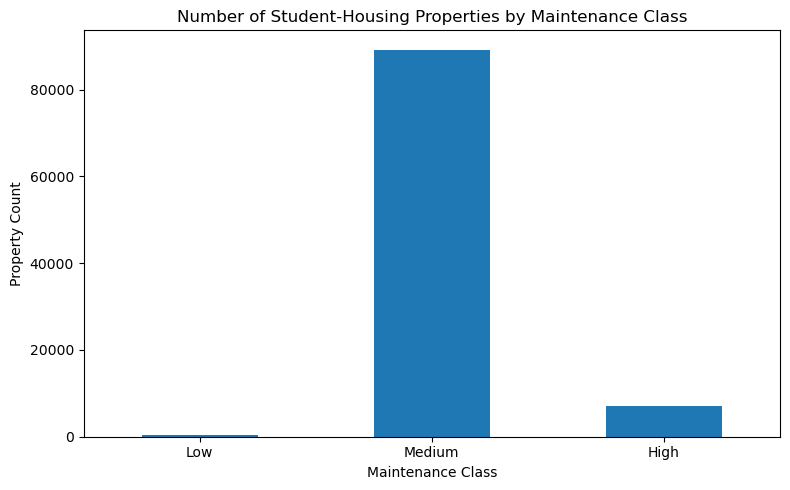

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Count how many properties are in each maintenance class
counts = df['CONDITION_CLASS'].value_counts().reindex(['Low', 'Medium', 'High'])

# Plot the bar chart
counts.plot(kind='bar')

# Add chart titles and labels
plt.title("Number of Student-Housing Properties by Maintenance Class")
plt.xlabel("Maintenance Class")
plt.ylabel("Property Count")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Part Two Recap & Insights

In Part Two, we built both a 3-class classifier (Low / Medium / High maintenance) and a regressor (combined INT + EXT score on a 2–10 scale) using a Random Forest model.

### Feature Set:
- **Owner Type**: Individual, Company, Institutional, Unknown  
- **Property Metrics**: Count of residential & commercial units, total / land / building assessed values  
- **Neighborhood Context**: Pivoted counts of 311 housing-related complaints (Inspection, Violation, Sanitation, Maintenance, Housing) for each student area

We split approximately 19,000 properties into:
- **60% training**
- **20% validation**
- **20% test**  
All features were scaled before modeling.

---

### Model Results

| Task          | Metric        | Score |
|---------------|---------------|-------|
| Classification | Accuracy      | 0.91  |
|                | Medium F₁     | 0.95  |
|                | High F₁       | 0.40  |
|                | Low F₁        | 0.19  |
| Regression     | MSE           | 0.76  |
|                | R²            | 0.39  |

---

### What This Tells Us

- **Dominance of “Average” Maintenance**  
  Nearly 92% of properties fall into the Medium bucket. Our classifier handles this large class very well (F₁ ≈ 0.95). This suggests most off-campus student housing receives average upkeep.

- **Challenges at the Extremes**  
  Well-maintained ("High") or poorly maintained ("Low") buildings are rare (less than 10% combined), and the model often misclassifies them as Medium.  
  - High recall ≈ 0.39  
  - Low recall ≈ 0.12  

- **311 Complaints Add Signal — But Not the Whole Story**  
  Adding neighborhood complaint counts increased our regression model's explanatory power to R² ≈ 0.39. This shows complaints are correlated with maintenance, but they leave ~60% of the variation unexplained.

---

### Implications for Student Housing

- Most properties behave like the “average” case — neither exceptional nor highly problematic.  
- Accurately flagging outliers (very poor or very well-maintained buildings) will require richer data — such as:
  - Building age  
  - Renovation history  
  - Amenity inventories  
  - Tenant feedback or satisfaction surveys  

- 311 data is a useful lightweight, public proxy for localized maintenance pressure, but needs to be combined with deeper property-level attributes for more reliable predictions and outlier detection.
